In [ ]:
#Original code for this cell at https://github.com/theofil/dscout/blob/master/analysis/exampleAnalysis.ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess
import bz2


plt.rc('font', size=15)



# data files
path = './data/hiion/' #  The files in this path have been manually processed (removed empty files, and merged a run with two parts into one)
#You can find the code for the file processing at https://github.com/GeorgeAlex22/scout/blob/master/DataFileCleaning.ipynb 
files = os.listdir(path)
files = [f for f in files if 'monitor' not in f]

# getrunNumber from string e.g., int('/data/hiion/scout_326676_000000.monitor.txt'.split('_')[1]
getRun = lambda x: int(x.split('_')[1])



# list to hold dataframes
dfs = []
runIndex= []

for file in files:
    filepath = path+file
    df = pd.read_csv(filepath)
    
  
    # add a column with the run number
    df['run'] = getRun(file) 
    dfs += [df]
    
    #make in index with the run numbers
    runIndex += [getRun(file)]
plt.rc('figure', max_open_warning = 100)




In [ ]:
#Fix the runs where the orbit number resets (the warning does not matter)

for df in dfs:
    if not df['orbit'].is_monotonic:
        for i in range(1,len(df)):
            if df['orbit'][i-1]>df['orbit'][i]:
                tmp = i-1
                break
        df['orbit'][tmp:] = df['orbit'][tmp-1] + df['orbit'][tmp:]
            

In [4]:
# The bad runs were manually chosen
badruns = [0, 1, 4, 8, 9, 11, 28, 30, 33, 34, 35, 36, 39, 46, 47, 50,  57, 65, 68, 69, 70, 72, 77, 78]
goodruns = [i for i in range(len(dfs)) if i not in badruns]

In [5]:
dfg = [] #data frame with only goodruns

for i in range(len(dfs)):
    if i in goodruns : dfg.append(dfs[i])

In [6]:
dif = []

for j in [23,24]:
    k=np.zeros(len(dfg[j]))
    for i in range(len(dfg[j])):
        if i == 0: k[i] = 0
        else: k[i] = dfg[j]['orbit'][i]-dfg[j]['orbit'][i-1]

    dif.append(k)

In [7]:
# Make the orbit run for every data frame start from 1
for j in [23,24]:
    dfg[j]['orbit'][0] = 1
    for i in range(1, len(dfg[j])):
        dfg[j]['orbit'][i] = dfg[j]['orbit'][i-1]+dif[j-23][i]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [8]:
for j in [23,24]:
    if j>23:
        dfg[j]['orbit']+=dfg[j-1]['orbit'].tolist()[-1]

In [9]:
merged = pd.concat([dfg[23], dfg[24]], ignore_index=True, sort=False)


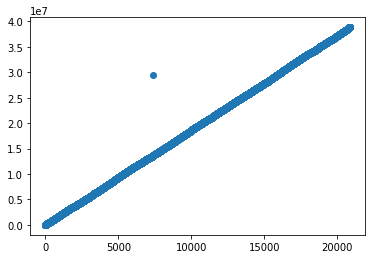

In [10]:
plt.scatter([i for i in range(len(merged))],merged['orbit'])

#this lonely dot needs a fix

In [12]:
# for each orbit, we dump in the CSV 110 BX's (= bxMax - bxMin) that 'sit' in the LHC abort gap (end of the train)
# that is, each orbit in the CSV corresponds to 110*24.95 ns of active recorded time, due to our selection made 
# (we dump in CSV only a part of each orbit during the LHC abort gap)
timePerOrbit = 110*24.95
print('timePerOrbit %2.1f ns '%timePerOrbit)

timeUnit = 0.2*1e9 # desired time unit in seconds
orbitsPerTimeUnit = timeUnit/timePerOrbit
print('orbitsPerTimeUnit = %2.3f'%orbitsPerTimeUnit)





orbitMin  = merged['orbit'][:1].values[0]
orbitMax  = merged['orbit'][-1:].values[0] 
rectime   = (orbitMax-orbitMin)*timePerOrbit # in ns
print('orbitMin %d orbitMax %d'%(orbitMin, orbitMax))
print('nOrbits %d '%(orbitMax - orbitMin))
print('total recording time %2.4f ns (~= %2.1f s)' %(rectime, rectime*1.e-9))

bins=int((orbitMax-orbitMin)/orbitsPerTimeUnit) 
timePerBin = rectime/bins

muons=np.zeros(bins)
sclice=np.array([merged['orbit'].min()+ ((merged['orbit'].max()-merged['orbit'].min())/bins)*i for i in range(bins+1)])
for orbit in merged['orbit']:
    for i in range(bins):
        if(orbit >= sclice[i] and orbit < sclice[i+1]): # note the >=, the = is needed to capture first orbit
            muons[i]+=1
        if(orbit == orbitMax and orbit == sclice[i+1]): # note the ==, is needed to capture last orbit
                                                        # last bin is [leftedge,rightedge] and not [leftedge,rightedge)
                muons[i]+=1


timePerOrbit 2744.5 ns 
orbitsPerTimeUnit = 72873.019
orbitMin 1 orbitMax 38846835
nOrbits 38846834 
total recording time 106615135913.0000 ns (~= 106.6 s)


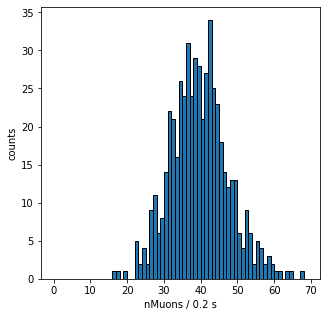

In [13]:
maxBins = 70
plt.figure(figsize=(5,5))
binCounts, bin_edges, patches = plt.hist(muons, bins= [i for i in range(maxBins)], histtype = 'bar', ec='black', density = False)
plt.xlabel('nMuons / %2.1f s'%(timePerBin*1.e-9)) # latex can be entered in the label's string
plt.ylabel('counts')
plt.show()

326886


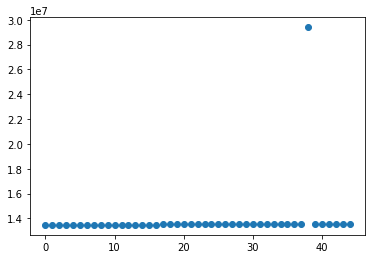

In [34]:
plt.scatter([i for i in range(45)],dfg[24]['orbit'][:45])

print(dfg[24]['run'][0])
#  We can see that the lonely dot appears at the entry with index 38, in the run 326886. It propably does not alter the rate distribution that much, but nevertheless it need to be fixed.